In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import warnings
import math
from dataclasses import dataclass
from typing import Tuple, Optional
warnings.filterwarnings('ignore')

In [ ]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    Sigmoid function.
    """
    return 1.0 / (1.0 + np.exp(-x))

def calibrate_intercept_for_prevalence(
    linpred_no_intercept: np.ndarray,
    target_prevalence: float,
    max_iter: int = 60,
) -> float:
    """
    Find an intercept b0 such that the average treatment probability 
    equals a desired prevalence.
    """
    lo, hi = -20.0, 20.0
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        p = sigmoid(mid + linpred_no_intercept).mean()
        if p < target_prevalence:
            lo = mid
        else:
            hi = mid
    return 0.5 * (lo + hi)

def weibull_ph_time_paper(
    u01: np.ndarray, 
    k: float, 
    lam: float,
    eta: np.ndarray) -> np.ndarray:
    """
    Generates survival times from a Weibull proportional hazards model, 
    using inverse-CDF sampling.
    """
    u01 = np.clip(u01, 1e-12, 1 - 1e-12)
    scale = lam * np.exp(-eta / k)
    return scale * (-np.log(u01)) ** (1.0 / k)

@dataclass
class SynthConfig:
    n: int = 5000                               # sample size
    p_x: int = 10                               # number of covariates
    seed: int = 123

    # Treatment (W_i) assignment parameters
    w_prevalence: float = 0.5                   # target treatment prevalence
    gamma_u_in_w: float = 1.0                   # strength of unmeasured confounding in treatment (gamma_U)

    # Survival (T_i(w)) outcome parameters
    k_t: float = 1.5                            # Weibull shape
    lam_t: float = 0.4                          # Weibull scale
    tau_log_hr: float = -0.6                    # log hazard ratio for treatment effect (tau)
    beta_u_in_t: float = 0.8                    # strength of unmeasured confounding in outcome (beta_U)
    
    # Censoring parameters
    k_c: float = 1.2                            # Weibull shape
    lam_c: Optional[float] = None               # Weibull scale (if None, will be calibrated)
    beta_u_in_c: float = 0.3                    # strength of unmeasured confounding in censoring (beta_U)
    target_censor_rate: float = 0.35
    max_censor_calib_iter: int = 60             # iteration control for binary search when calibrating censoring
    censor_lam_lo: float = 1e-8
    censor_lam_hi: float = 1e6
    admin_censor_time: Optional[float] = None   # a fixed administrative censoring cutoff time

    # Negative control variables parameters
    az: float = 1.0                             # coefficient for U in Z
    av: float = 1.0                             # coefficient for U in V
    sigma_z: float = 0.8                        # std dev of measurement error in Z
    sigma_v: float = 0.8                        # std dev of measurement error in V

@dataclass
class SynthParams:

    # Coefficient vectors of observed covariates X
    b_z: np.ndarray
    b_v: np.ndarray
    beta_t: np.ndarray

def generate_synthetic_nc_cox(cfg: SynthConfig) -> Tuple[pd.DataFrame, pd.DataFrame, SynthParams]:
    """
    Generate synthetic survival data with:
      - unmeasured confounding (latent U)
      - treatment assignment confounded by U
      - Weibull proportional hazards outcome model
      - Weibull censoring model (possibly informative)
      - two negative control variables Z and V

    Returns:
      observed_df: pd.DataFrame
          What an analyst observes (time, event, W, X, Z, V)
      truth_df: pd.DataFrame
          Latent variables and counterfactual outcomes (for evaluation only)
      params: SynthParams
          True coefficient vectors used in the DGP
    """
    rng = np.random.default_rng(cfg.seed)
    n, p = cfg.n, cfg.p_x

    X = rng.normal(size=(n, p))
    U = rng.normal(size=n)

    # --------------------------------------------------------------------------
    # Generate negative control variables Z and V
    b_z = rng.normal(scale=0.3, size=p)
    b_v = rng.normal(scale=0.3, size=p)

    Z = cfg.az * U + X @ b_z + rng.normal(scale=cfg.sigma_z, size=n)
    V = cfg.av * U + X @ b_v + rng.normal(scale=cfg.sigma_v, size=n)
    
    # --------------------------------------------------------------------------
    # Generate treatment W
    alpha = rng.normal(scale=0.5, size=p)
    linpred = X @ alpha + cfg.gamma_u_in_w * U
    b0 = calibrate_intercept_for_prevalence(linpred, cfg.w_prevalence)

    p_w = sigmoid(b0 + linpred)
    W = rng.binomial(1, p_w, size=n).astype(int)

    # --------------------------------------------------------------------------
    # Generate survival times T
    beta_t = rng.normal(scale=0.4, size=p)
    u_t = rng.random(n)

    # ηi(w) = β_t^T * Xi +β_u * U_i +τw
    eta_t0 = X @ beta_t + cfg.beta_u_in_t * U + cfg.tau_log_hr * 0.0
    eta_t1 = X @ beta_t + cfg.beta_u_in_t * U + cfg.tau_log_hr * 1.0

    T0 = weibull_ph_time_paper(u_t, k=cfg.k_t, lam=cfg.lam_t, eta=eta_t0)
    T1 = weibull_ph_time_paper(u_t, k=cfg.k_t, lam=cfg.lam_t, eta=eta_t1)

    # --------------------------------------------------------------------------
    # Generate censoring times C
    beta_c = rng.normal(scale=0.3, size=p)
    u_c = rng.random(n)
    
    eta_c0 = X @ beta_c + cfg.beta_u_in_c * U
    eta_c1 = X @ beta_c + cfg.beta_u_in_c * U

    T_obs_for_calib = np.where(W == 1, T1, T0)
    lam_c_used = cfg.lam_c
    if lam_c_used is None:
        lo, hi = float(cfg.censor_lam_lo), float(cfg.censor_lam_hi)
        for _ in range(cfg.max_censor_calib_iter):
            mid = 0.5 * (lo + hi)
            C0_mid = weibull_ph_time_paper(u_c, k=cfg.k_c, lam=mid, eta=eta_c0)
            C1_mid = weibull_ph_time_paper(u_c, k=cfg.k_c, lam=mid, eta=eta_c1)
            C_obs_mid = np.where(W == 1, C1_mid, C0_mid)
            censor_rate_mid = (C_obs_mid < T_obs_for_calib).mean()
            if censor_rate_mid < cfg.target_censor_rate:
                hi = mid
            else:
                lo = mid
        lam_c_used = 0.5 * (lo + hi)

    C0 = weibull_ph_time_paper(u_c, k=cfg.k_c, lam=lam_c_used, eta=eta_c0)
    C1 = weibull_ph_time_paper(u_c, k=cfg.k_c, lam=lam_c_used, eta=eta_c1)

    T = np.where(W == 1, T1, T0)
    C = np.where(W == 1, C1, C0)
    time = np.minimum(T, C)
    event = (T <= C).astype(int)

    if cfg.admin_censor_time is not None:
        admin = float(cfg.admin_censor_time)
        cens_by_admin = admin < time
        time = np.where(cens_by_admin, admin, time)
        event = np.where(cens_by_admin, 0, event).astype(int)

    # --------------------------------------------------------------------------
    # Assemble observed dataframe
    X_cols = {f"X{j}": X[:, j] for j in range(p)}

    observed_df = pd.DataFrame({"time": time, "event": event, "W": W, "A": W, "Z": Z, "V": V, **X_cols})

    # --------------------------------------------------------------------------
    # Assemble truth dataframe
    truth_df = observed_df.copy()
    truth_df.insert(0, "U", U)
    truth_df["T0"] = T0
    truth_df["T1"] = T1
    truth_df["C0"] = C0
    truth_df["C1"] = C1
    truth_df["T"] = T
    truth_df["C"] = C
    truth_df.attrs["lam_c_used"] = lam_c_used

    params = SynthParams(b_z=b_z, b_v=b_v, beta_t=beta_t)
    return observed_df, truth_df, params

def add_eq8_eq9_columns(
    observed_df: pd.DataFrame,
    truth_df: pd.DataFrame,
    cfg: SynthConfig,
    params: SynthParams,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    obs = observed_df.copy()
    tru = truth_df.copy()
    """
    Augment observed and truth dataframes with “oracle” / benchmarking quantities derived from the
    negative-control Gaussian measurement model and the Weibull PH event-time model.

    Returns:
      obs: pd.DataFrame
        Copy of observed_df with additional columns:
        - tildeZ, tildeV
        - mu_U_post, var_U_post
        - CATE_XZV_eq9
      tru: pd.DataFrame
        Copy of truth_df with additional columns:
        - CATE_XU_eq7
        - ITE_T1_minus_T0
    """
    x_cols = sorted([c for c in obs.columns if c.startswith("X")], key=lambda s: int(s[1:]))
    X = obs[x_cols].to_numpy()
    Z = obs["Z"].to_numpy()
    V = obs["V"].to_numpy()

    # Z̃ = Z - X b_z
    tildeZ = Z - X @ params.b_z
    tildeV = V - X @ params.b_v

    az, av = float(cfg.az), float(cfg.av)                           # coefficients for U in Z and V
    sz2, sv2 = float(cfg.sigma_z) ** 2, float(cfg.sigma_v) ** 2     # variances of measurement errors
    denom = (az**2) * sv2 + (av**2) * sz2 + sz2 * sv2               # common denominator

    mu_post = (az * sv2 * tildeZ + av * sz2 * tildeV) / denom
    var_post = (sz2 * sv2) / denom

    k = float(cfg.k_t)
    lam = float(cfg.lam_t)
    tau = float(cfg.tau_log_hr)
    beta_u = float(cfg.beta_u_in_t)

    G = math.gamma(1.0 + 1.0 / k)                                   # Γ(1 + 1/k)                           
    xb = X @ params.beta_t

    # --------------------------------------------------------------------------
    # oracle CATE formula conditioning on (X,Z,V) via the posterior of U
    cate_xzv = (
        lam * G * np.exp(-(1.0 / k) * xb -(beta_u / k) * mu_post + 0.5 * (beta_u**2) * var_post / (k**2))
        * (np.exp(-tau / k) - 1.0)
    )

    # --------------------------------------------------------------------------
    # oracle CATE formula conditioning on (X,U)
    U = tru["U"].to_numpy()
    cate_xu = (lam * G * np.exp(-(1.0 / k) * (xb + beta_u * U)) * (np.exp(-tau / k) - 1.0))

    # --------------------------------------------------------------------------
    # true individual treatment effect on event time: T(1) - T(0)
    ite = tru["T1"].to_numpy() - tru["T0"].to_numpy()

    obs["tildeZ"] = tildeZ
    obs["tildeV"] = tildeV
    obs["mu_U_post"] = mu_post
    obs["var_U_post"] = var_post
    obs["CATE_XZV_eq9"] = cate_xzv

    tru["CATE_XU_eq7"] = cate_xu
    tru["ITE_T1_minus_T0"] = ite

    return obs, tru

## Generate Synthetic Data (Non-Censored)

We'll use a very large `lam_c` to ensure almost no censoring, focusing on the unobserved confounding challenge.

In [75]:
cfg = SynthConfig(
    n=10000,
    p_x=10,
    lam_c=1e6,
    seed=42,
)

obs_df, truth_df, params = generate_synthetic_nc_cox(cfg)
obs_df, truth_df = add_eq8_eq9_columns(obs_df, truth_df, cfg, params)

print(f"Dataset size: {len(obs_df)}")
print(f"Censoring rate: {1 - obs_df['event'].mean():.3f}")
print(f"Treatment prevalence: {obs_df['W'].mean():.3f}")
print(f"\nGround truth CATE (Eq.7, true U): mean={truth_df['CATE_XU_eq7'].mean():.4f}, std={truth_df['CATE_XU_eq7'].std():.4f}")
print(f"Proxy-based CATE (Eq.9): mean={obs_df['CATE_XZV_eq9'].mean():.4f}, std={obs_df['CATE_XZV_eq9'].std():.4f}")

Dataset size: 10000
Censoring rate: 0.000
Treatment prevalence: 0.500

Ground truth CATE (Eq.7, true U): mean=0.3266, std=0.4902
Proxy-based CATE (Eq.9): mean=0.3261, std=0.4618


In [76]:
# Prepare train/test split
x_cols = [c for c in obs_df.columns if c.startswith('X')]
X = obs_df[x_cols].values
W = obs_df['W'].values
Y = obs_df['time'].values  # For non-censored, time is essentially T
Z = obs_df['Z'].values
V_proxy = obs_df['V'].values
U_true = truth_df['U'].values

# Ground truth
true_cate = truth_df['CATE_XU_eq7'].values
true_ite = truth_df['ITE_T1_minus_T0'].values

# Split
(
    X_train, X_test,
    W_train, W_test,
    Y_train, Y_test,
    Z_train, Z_test,
    V_train, V_test,
    U_train, U_test,
    cate_train, cate_test,
    ite_train, ite_test
) = train_test_split(
    X, W, Y, Z, V_proxy, U_true, true_cate, true_ite,
    test_size=0.3, random_state=42
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 7000, Test size: 3000


## Method 1: CSF Baseline (EconML)

Standard Causal Survival Forest that ignores the unobserved confounder $U$. This will be biased.

In [77]:
from econml.grf import CausalForest

# Train CSF baseline (ignoring U)
csf_baseline = CausalForest(
    n_estimators=200,
    min_samples_leaf=30,
    random_state=42
)

csf_baseline.fit(X_train, W_train, Y_train)

# Predict CATE (flatten to 1D)
cate_pred_baseline = csf_baseline.predict(X_test).flatten()

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score

mse_baseline = mean_squared_error(cate_test, cate_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(cate_test, cate_pred_baseline)
corr_baseline = np.corrcoef(cate_test, cate_pred_baseline)[0, 1]

print("\n=== CSF Baseline (econml) ===")
print(f"RMSE: {rmse_baseline:.4f}")
print(f"R²: {r2_baseline:.4f}")
print(f"Correlation: {corr_baseline:.4f}")
print(f"Mean predicted CATE: {cate_pred_baseline.mean():.4f}")
print(f"Mean true CATE: {cate_test.mean():.4f}")


=== CSF Baseline (econml) ===
RMSE: 0.5469
R²: -0.2909
Correlation: 0.2896
Mean predicted CATE: 0.0289
Mean true CATE: 0.3207


## Method 2: NC-CSF with Estimated Bridge Functions

Following the paper, we need to modify the **score function** used in GRF. 

**Standard CSF score** (Eq. 1, uncensored case):
$$\psi_\tau^{(c)}(X_i, Y_i, A_i) = [A_i - e(X_i)][Y_i - m(X_i) - \tau(A_i - e(X_i))]$$

**NC-CSF modified score** (Eq. 6):
$$\tilde{\psi}_\tau^{(c)}(X_i, Y_i, A_i, W_i, Z_i) = [A_i - q(Z_i, 1, X_i)][Y_i - m(X_i, W_i, Z_i) - \tau(A_i - q(Z_i, 1, X_i))]$$

where $m(X_i, W_i, Z_i) = q(Z_i, 1, X_i) h(W_i, 1, X_i) + (1 - q(Z_i, 1, X_i)) h(W_i, 0, X_i)$

The bridge functions $q$ and $h$ replace the standard propensity $e(X)$ and outcome model components. This score is used in:
1. **Splitting criterion** - find splits that maximize heterogeneity in τ
2. **Leaf estimation** - solve for τ such that the score averages to zero

In [78]:
# =============================================================================
# NC-CSF Implementation: Modified GRF with Bridge Function Score (Eq. 6)
# =============================================================================

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import brentq

class NCCausalSurvivalForest:
    """
    Negative Control Causal Survival Forest.
    
    Implements the modified score function from Eq. (6):
    ψ̃_τ(X,Y,A,W,Z) = [A - q(Z,1,X)] * [Y - m(X,W,Z) - τ*(A - q(Z,1,X))]
    
    where:
    - q(Z, A, X) is the action bridge function
    - h(W, A, X) is the outcome bridge function  
    - m(X,W,Z) = q*h(W,1,X) + (1-q)*h(W,0,X)
    """
    
    def __init__(self, n_estimators=100, min_samples_leaf=5, max_depth=None,
                 subsample_ratio=0.5, random_state=None):
        self.n_estimators = n_estimators
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.subsample_ratio = subsample_ratio
        self.random_state = random_state
        self.trees = []
        self.q_model = None  # Action bridge
        self.h1_model = None  # Outcome bridge for A=1
        self.h0_model = None  # Outcome bridge for A=0
        
    def _estimate_bridge_functions(self, X, A, Y, Z, W):
        """
        Estimate the bridge functions q and h.
        
        Action bridge q(Z, A, X): function of (Z, X) only
        Outcome bridge h(W, A, X): function of (W, X) only
        """
        # Action bridge: q(Z, 1, X) estimated via P(A=1 | Z, X)
        XZ = np.column_stack([X, Z])
        self.q_model = LogisticRegression(max_iter=1000, random_state=self.random_state)
        self.q_model.fit(XZ, A)
        
        # Outcome bridge: h(W, A, X) estimated via E[Y | W, X, A]
        XW = np.column_stack([X, W])
        
        treated_mask = A == 1
        control_mask = A == 0
        
        self.h1_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=30, 
                                               random_state=self.random_state)
        self.h0_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=30,
                                               random_state=self.random_state)
        
        if treated_mask.sum() > 0:
            self.h1_model.fit(XW[treated_mask], Y[treated_mask])
        if control_mask.sum() > 0:
            self.h0_model.fit(XW[control_mask], Y[control_mask])
    
    def _compute_score_components(self, X, A, Y, Z, W):
        """
        Compute the components needed for the NC-CSF score function.
        """
        XZ = np.column_stack([X, Z])
        XW = np.column_stack([X, W])
        
        # q(Z, 1, X) - action bridge
        q = self.q_model.predict_proba(XZ)[:, 1]
        q = np.clip(q, 0.01, 0.99)
        
        # h(W, 1, X) and h(W, 0, X) - outcome bridges
        h1 = self.h1_model.predict(XW)
        h0 = self.h0_model.predict(XW)
        
        # m(X, W, Z) = q * h1 + (1-q) * h0
        m = q * h1 + (1 - q) * h0
        
        return q, m, h1, h0
    
    def _compute_score(self, A, Y, q, m, tau):
        """
        Compute the NC-CSF score function (Eq. 6):
        ψ̃_τ = [A - q] * [Y - m - τ*(A - q)]
        """
        A_centered = A - q
        return A_centered * (Y - m - tau * A_centered)
    
    def _solve_tau_leaf(self, A, Y, q, m):
        """
        Solve for τ in a leaf by finding τ such that E[ψ̃_τ] = 0.
        
        τ = E[(A-q)(Y-m)] / E[(A-q)²]
        """
        A_centered = A - q
        numerator = np.mean(A_centered * (Y - m))
        denominator = np.mean(A_centered ** 2)
        
        if np.abs(denominator) < 1e-10:
            return 0.0
        
        return numerator / denominator
    
    def _build_tree(self, X, A, Y, Z, W, q, m, h1, h0, rng):
        """
        Build a single tree using the NC-CSF splitting criterion.
        """
        n = len(Y)
        
        # Subsample for honesty
        subsample_size = int(n * self.subsample_ratio)
        indices = rng.choice(n, size=subsample_size, replace=False)
        
        # Use half for splitting, half for estimation (honesty)
        split_size = subsample_size // 2
        split_idx = indices[:split_size]
        est_idx = indices[split_size:]
        
        tau_split = self._solve_tau_leaf(A[split_idx], Y[split_idx], 
                                          q[split_idx], m[split_idx])
        
        # Pseudo-outcome for tree splitting
        A_centered_split = A[split_idx] - q[split_idx]
        var_A = np.var(A_centered_split) + 1e-10
        pseudo_outcome = A_centered_split * (Y[split_idx] - m[split_idx]) / var_A
        
        # Fit tree on pseudo-outcomes
        tree = DecisionTreeRegressor(
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            random_state=rng.integers(1e9)
        )
        tree.fit(X[split_idx], pseudo_outcome)
        
        # Get leaf assignments for estimation sample
        leaves_est = tree.apply(X[est_idx])
        unique_leaves = np.unique(leaves_est)
        
        # Compute tau for each leaf using estimation sample
        leaf_tau = {}
        for leaf in unique_leaves:
            leaf_mask = leaves_est == leaf
            if leaf_mask.sum() >= 2:
                leaf_tau[leaf] = self._solve_tau_leaf(
                    A[est_idx][leaf_mask],
                    Y[est_idx][leaf_mask],
                    q[est_idx][leaf_mask],
                    m[est_idx][leaf_mask]
                )
            else:
                leaf_tau[leaf] = tau_split
        
        return tree, leaf_tau, est_idx
    
    def fit(self, X, A, Y, Z, W):
        """Fit the NC-CSF model."""
        rng = np.random.default_rng(self.random_state)
        
        print("Estimating bridge functions...")
        self._estimate_bridge_functions(X, A, Y, Z, W)
        
        q, m, h1, h0 = self._compute_score_components(X, A, Y, Z, W)
        
        print(f"  Action bridge q: mean={q.mean():.3f}, std={q.std():.3f}")
        print(f"  Outcome bridge h1: mean={h1.mean():.3f}")
        print(f"  Outcome bridge h0: mean={h0.mean():.3f}")
        
        print(f"Building forest with {self.n_estimators} trees...")
        self.trees = []
        for b in range(self.n_estimators):
            tree, leaf_tau, est_idx = self._build_tree(X, A, Y, Z, W, q, m, h1, h0, rng)
            self.trees.append((tree, leaf_tau))
        
        self._X_train = X
        self._Z_train = Z
        self._W_train = W
        
        return self
    
    def predict(self, X, Z, W):
        """Predict CATE for new observations."""
        n = X.shape[0]
        predictions = np.zeros(n)
        
        for tree, leaf_tau in self.trees:
            leaves = tree.apply(X)
            for i in range(n):
                if leaves[i] in leaf_tau:
                    predictions[i] += leaf_tau[leaves[i]]
                else:
                    predictions[i] += np.mean(list(leaf_tau.values()))
        
        return predictions / self.n_estimators

print("NCCausalSurvivalForest class defined successfully.")

NCCausalSurvivalForest class defined successfully.


## Method 3: NC-CSF with Correct Bridge Functions

Using the **true/known bridge functions** derived from the data generating process. Since we know the DGP parameters, we can compute the exact bridge functions analytically rather than estimating them.

For the **action bridge** $q(Z, A, X)$, we use $E[U | Z, X]$:
$$E[U | Z, X] = \frac{a_Z}{a_Z^2 + \sigma_Z^2} \tilde{Z}$$

For the **outcome bridge** $h(W, A, X)$, we use $E[U | W, X]$:
$$E[U | W, X] = \frac{a_V}{a_V^2 + \sigma_V^2} \tilde{W}$$

where $\tilde{Z} = Z - X^\top b_Z$ and $\tilde{W} = W - X^\top b_W$.

In [79]:
# =============================================================================
# NC-CSF with CORRECT (True) Bridge Functions
# =============================================================================

class NCCSFCorrectBridge(NCCausalSurvivalForest):
    """
    NC-CSF using the analytically correct bridge functions.
    
    Uses TRUE DGP parameters to compute exact posteriors:
    - Action bridge uses E[U | Z, X] (only Z)
    - Outcome bridge uses E[U | W, X] (only W)
    """
    
    def __init__(self, cfg, params, **kwargs):
        super().__init__(**kwargs)
        self.cfg = cfg
        self.dgp_params = params
        
    def _compute_posterior_U_from_Z(self, X, Z):
        """
        Compute E[U | Z, X] using only Z (for action bridge).
        E[U | Z, X] = a_Z / (a_Z² + σ_Z²) * (Z - X'b_Z)
        """
        Z_tilde = Z - X @ self.dgp_params.b_z
        az = self.cfg.az
        sz2 = self.cfg.sigma_z**2
        mu_U_from_Z = (az / (az**2 + sz2)) * Z_tilde
        return mu_U_from_Z
    
    def _compute_posterior_U_from_W(self, X, W):
        """
        Compute E[U | W, X] using only W (for outcome bridge).
        E[U | W, X] = a_V / (a_V² + σ_V²) * (W - X'b_V)
        """
        W_tilde = W - X @ self.dgp_params.b_v
        av = self.cfg.av
        sv2 = self.cfg.sigma_v**2
        mu_U_from_W = (av / (av**2 + sv2)) * W_tilde
        return mu_U_from_W
    
    def _estimate_bridge_functions(self, X, A, Y, Z, W):
        """
        Use correct bridge functions based on true posterior of U.
        
        Action bridge q(Z, A, X): Uses E[U | Z, X] (only Z, not W)
        Outcome bridge h(W, A, X): Uses E[U | W, X] (only W, not Z)
        """
        # Action bridge q(Z, 1, X): function of (Z, X)
        mu_U_from_Z = self._compute_posterior_U_from_Z(X, Z)
        X_Z_features = np.column_stack([X, mu_U_from_Z])
        
        self.q_model = LogisticRegression(max_iter=1000, random_state=self.random_state)
        self.q_model.fit(X_Z_features, A)
        
        # Outcome bridge h(W, A, X): function of (W, X)
        mu_U_from_W = self._compute_posterior_U_from_W(X, W)
        X_W_features = np.column_stack([X, mu_U_from_W])
        
        treated_mask = A == 1
        control_mask = A == 0
        
        self.h1_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=30,
                                               random_state=self.random_state)
        self.h0_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=30,
                                               random_state=self.random_state)
        
        if treated_mask.sum() > 0:
            self.h1_model.fit(X_W_features[treated_mask], Y[treated_mask])
        if control_mask.sum() > 0:
            self.h0_model.fit(X_W_features[control_mask], Y[control_mask])
    
    def _compute_score_components(self, X, A, Y, Z, W):
        """Compute score components using correct bridge functions."""
        # Action bridge: q(Z, 1, X) - function of Z, X
        mu_U_from_Z = self._compute_posterior_U_from_Z(X, Z)
        X_Z_features = np.column_stack([X, mu_U_from_Z])
        q = self.q_model.predict_proba(X_Z_features)[:, 1]
        q = np.clip(q, 0.01, 0.99)
        
        # Outcome bridge: h(W, A, X) - function of W, X
        mu_U_from_W = self._compute_posterior_U_from_W(X, W)
        X_W_features = np.column_stack([X, mu_U_from_W])
        h1 = self.h1_model.predict(X_W_features)
        h0 = self.h0_model.predict(X_W_features)
        
        # m(X, W, Z) = q * h1 + (1-q) * h0
        m = q * h1 + (1 - q) * h0
        
        return q, m, h1, h0

print("NCCSFCorrectBridge class defined successfully.")

NCCSFCorrectBridge class defined successfully.


In [80]:
# =============================================================================
# Fit NC-CSF with Estimated Bridge Functions
# =============================================================================

nccsf_estimated = NCCausalSurvivalForest(
    n_estimators=200,
    min_samples_leaf=30,
    max_depth=12,
    subsample_ratio=0.6,
    random_state=42
)

# Fit the model - note we pass Z and V (negative control outcome)
nccsf_estimated.fit(X_train, W_train, Y_train, Z_train, V_train)

# Predict CATE
cate_pred_estimated = nccsf_estimated.predict(X_test, Z_test, V_test)

# Evaluate
mse_estimated = mean_squared_error(cate_test, cate_pred_estimated)
rmse_estimated = np.sqrt(mse_estimated)
r2_estimated = r2_score(cate_test, cate_pred_estimated)
corr_estimated = np.corrcoef(cate_test, cate_pred_estimated)[0, 1]

print("\n=== NC-CSF with Estimated Bridge Functions ===")
print(f"RMSE: {rmse_estimated:.4f}")
print(f"R²: {r2_estimated:.4f}")
print(f"Correlation: {corr_estimated:.4f}")
print(f"Mean predicted CATE: {cate_pred_estimated.mean():.4f}")
print(f"Mean true CATE: {cate_test.mean():.4f}")

Estimating bridge functions...
  Action bridge q: mean=0.504, std=0.326
  Outcome bridge h1: mean=0.857
  Outcome bridge h0: mean=0.736
Building forest with 200 trees...

=== NC-CSF with Estimated Bridge Functions ===
RMSE: 0.4499
R²: 0.1264
Correlation: 0.4020
Mean predicted CATE: 0.2341
Mean true CATE: 0.3207


In [81]:
# =============================================================================
# Fit NC-CSF with Correct Bridge Functions
# =============================================================================

nccsf_correct = NCCSFCorrectBridge(
    cfg=cfg,
    params=params,
    n_estimators=200,
    min_samples_leaf=30,
    max_depth=12,
    subsample_ratio=0.6,
    random_state=42
)

print("Fitting NC-CSF with CORRECT bridge functions...")
nccsf_correct.fit(X_train, W_train, Y_train, Z_train, V_train)

# Predict CATE
cate_pred_correct = nccsf_correct.predict(X_test, Z_test, V_test)

# Evaluate
mse_correct = mean_squared_error(cate_test, cate_pred_correct)
rmse_correct = np.sqrt(mse_correct)
r2_correct = r2_score(cate_test, cate_pred_correct)
corr_correct = np.corrcoef(cate_test, cate_pred_correct)[0, 1]

print("\n=== NC-CSF with CORRECT Bridge Functions ===")
print(f"RMSE: {rmse_correct:.4f}")
print(f"R²: {r2_correct:.4f}")
print(f"Correlation: {corr_correct:.4f}")
print(f"Mean predicted CATE: {cate_pred_correct.mean():.4f}")
print(f"Mean true CATE: {cate_test.mean():.4f}")

Fitting NC-CSF with CORRECT bridge functions...
Estimating bridge functions...
  Action bridge q: mean=0.504, std=0.326
  Outcome bridge h1: mean=0.882
  Outcome bridge h0: mean=0.721
Building forest with 200 trees...

=== NC-CSF with CORRECT Bridge Functions ===
RMSE: 0.4446
R²: 0.1470
Correlation: 0.4084
Mean predicted CATE: 0.2577
Mean true CATE: 0.3207


## Performance Comparison

In [82]:
# Summary table - All methods
results = pd.DataFrame({
    'Method': [
        'CSF Baseline',
        'NC-CSF (Estimated Bridge)',
        'NC-CSF (Correct Bridge)'
    ],
    'RMSE': [rmse_baseline, rmse_estimated, rmse_correct],
    'R²': [r2_baseline, r2_estimated, r2_correct],
    'Correlation': [corr_baseline, corr_estimated, corr_correct],
    'Mean CATE Pred': [
        cate_pred_baseline.mean(), 
        cate_pred_estimated.mean(),
        cate_pred_correct.mean()
    ]
})

print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(results.to_string(index=False))
print(f"\nTrue mean CATE: {cate_test.mean():.4f}")


PERFORMANCE COMPARISON
                   Method     RMSE        R²  Correlation  Mean CATE Pred
             CSF Baseline 0.546874 -0.290861     0.289573        0.028857
NC-CSF (Estimated Bridge) 0.449892  0.126383     0.401951        0.234073
  NC-CSF (Correct Bridge) 0.444555  0.146987     0.408358        0.257722

True mean CATE: 0.3207


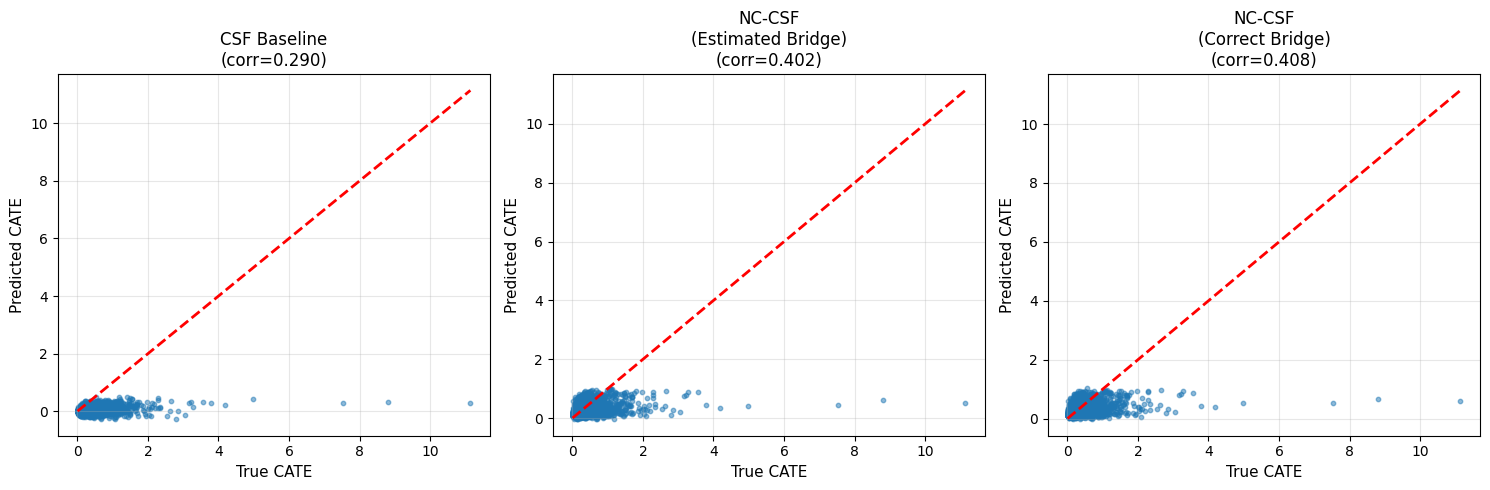

In [83]:
# Visualization - All methods
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = [
    ('CSF Baseline', cate_pred_baseline, corr_baseline),
    ('NC-CSF\n(Estimated Bridge)', cate_pred_estimated, corr_estimated),
    ('NC-CSF\n(Correct Bridge)', cate_pred_correct, corr_correct)
]

for ax, (name, pred, corr) in zip(axes, methods):
    ax.scatter(cate_test, pred, alpha=0.5, s=10)
    ax.plot([cate_test.min(), cate_test.max()], [cate_test.min(), cate_test.max()], 'r--', lw=2)
    ax.set_xlabel('True CATE', fontsize=11)
    ax.set_ylabel('Predicted CATE', fontsize=11)
    ax.set_title(f'{name}\n(corr={corr:.3f})', fontsize=12)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

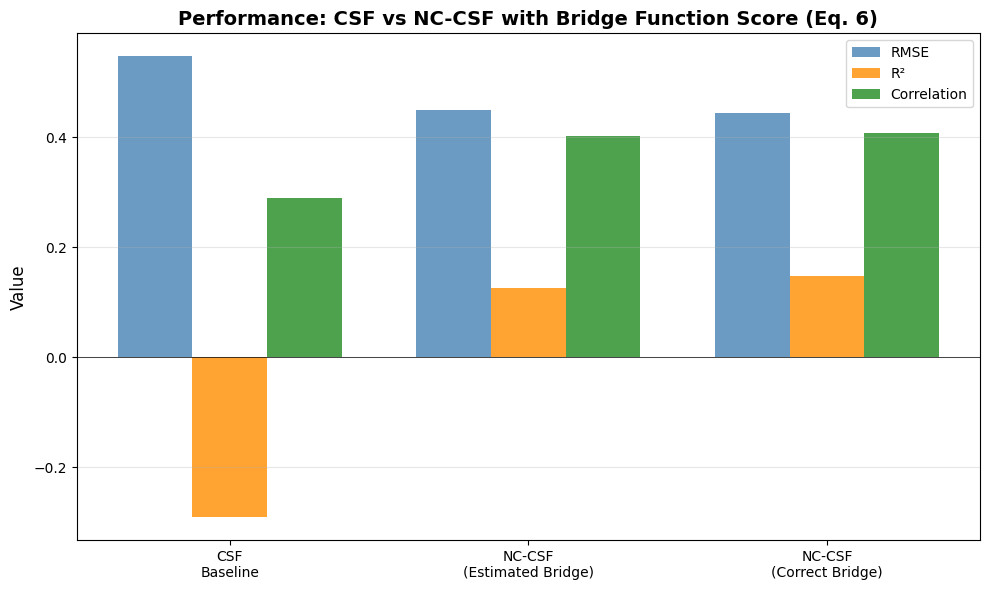

In [84]:
# Bar plot comparison - All methods
fig, ax = plt.subplots(figsize=(10, 6))

methods_names = ['CSF\nBaseline', 'NC-CSF\n(Estimated Bridge)', 'NC-CSF\n(Correct Bridge)']
x = np.arange(len(methods_names))
width = 0.25

rmse_vals = [rmse_baseline, rmse_estimated, rmse_correct]
r2_vals = [r2_baseline, r2_estimated, r2_correct]
corr_vals = [corr_baseline, corr_estimated, corr_correct]

ax.bar(x - width, rmse_vals, width, label='RMSE', alpha=0.8, color='steelblue')
ax.bar(x, r2_vals, width, label='R²', alpha=0.8, color='darkorange')
ax.bar(x + width, corr_vals, width, label='Correlation', alpha=0.8, color='forestgreen')

ax.set_ylabel('Value', fontsize=12)
ax.set_title('Performance: CSF vs NC-CSF with Bridge Function Score (Eq. 6)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods_names)
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## Additional Analysis: Effect of Confounding Strength

In [85]:
# Test with varying confounding strength
confounding_strengths = [0.0, 0.5, 1.0, 1.5, 2.0]
results_by_strength = []

for gamma_u in confounding_strengths:
    print(f"\nTesting with confounding strength γ_U = {gamma_u}...")
    
    cfg_temp = SynthConfig(n=10000, p_x=10, lam_c=1e6, seed=42, gamma_u_in_w=gamma_u)
    obs_temp, truth_temp, params_temp = generate_synthetic_nc_cox(cfg_temp)
    obs_temp, truth_temp = add_eq8_eq9_columns(obs_temp, truth_temp, cfg_temp, params_temp)
    
    X_temp = obs_temp[[c for c in obs_temp.columns if c.startswith('X')]].values
    W_temp = obs_temp['W'].values
    Y_temp = obs_temp['time'].values
    Z_temp = obs_temp['Z'].values
    V_temp = obs_temp['V'].values
    cate_temp = truth_temp['CATE_XU_eq7'].values
    
    X_tr, X_te, W_tr, W_te, Y_tr, Y_te, Z_tr, Z_te, V_tr, V_te, cate_tr, cate_te = train_test_split(
        X_temp, W_temp, Y_temp, Z_temp, V_temp, cate_temp, test_size=0.3, random_state=42
    )
    
    # Baseline CSF
    csf_base = CausalForest(n_estimators=200, min_samples_leaf=30, random_state=42)
    csf_base.fit(X_tr, W_tr, Y_tr)
    pred_base = csf_base.predict(X_te).flatten()
    rmse_base = np.sqrt(mean_squared_error(cate_te, pred_base))
    
    # NC-CSF with Correct Bridge
    nccsf_corr = NCCSFCorrectBridge(
        cfg=cfg_temp, params=params_temp,
        n_estimators=200, min_samples_leaf=30, max_depth=12, 
        subsample_ratio=0.6, random_state=42
    )
    nccsf_corr.fit(X_tr, W_tr, Y_tr, Z_tr, V_tr)
    pred_corr = nccsf_corr.predict(X_te, Z_te, V_te)
    rmse_corr = np.sqrt(mean_squared_error(cate_te, pred_corr))
    
    # NC-CSF with Estimated Bridge
    nccsf_est = NCCausalSurvivalForest(
        n_estimators=200, min_samples_leaf=30, max_depth=12,
        subsample_ratio=0.6, random_state=42
    )
    nccsf_est.fit(X_tr, W_tr, Y_tr, Z_tr, V_tr)
    pred_est = nccsf_est.predict(X_te, Z_te, V_te)
    rmse_est = np.sqrt(mean_squared_error(cate_te, pred_est))
    
    results_by_strength.append({
        'gamma_u': gamma_u,
        'rmse_baseline': rmse_base,
        'rmse_correct': rmse_corr,
        'rmse_estimated': rmse_est
    })

results_strength_df = pd.DataFrame(results_by_strength)
print("\n" + results_strength_df.to_string(index=False))


Testing with confounding strength γ_U = 0.0...
Estimating bridge functions...
  Action bridge q: mean=0.505, std=0.333
  Outcome bridge h1: mean=1.018
  Outcome bridge h0: mean=0.667
Building forest with 200 trees...
Estimating bridge functions...
  Action bridge q: mean=0.505, std=0.333
  Outcome bridge h1: mean=1.016
  Outcome bridge h0: mean=0.668
Building forest with 200 trees...

Testing with confounding strength γ_U = 0.5...
Estimating bridge functions...
  Action bridge q: mean=0.504, std=0.329
  Outcome bridge h1: mean=0.958
  Outcome bridge h0: mean=0.691
Building forest with 200 trees...
Estimating bridge functions...
  Action bridge q: mean=0.504, std=0.329
  Outcome bridge h1: mean=0.944
  Outcome bridge h0: mean=0.705
Building forest with 200 trees...

Testing with confounding strength γ_U = 1.0...
Estimating bridge functions...
  Action bridge q: mean=0.504, std=0.326
  Outcome bridge h1: mean=0.882
  Outcome bridge h0: mean=0.721
Building forest with 200 trees...
Estima

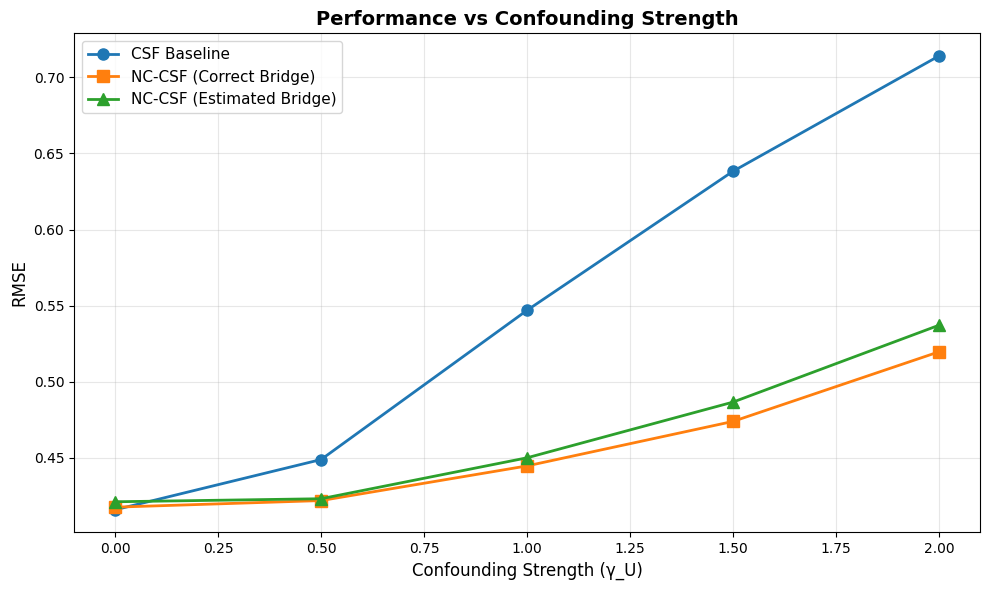

In [86]:
# Plot confounding effect
plt.figure(figsize=(10, 6))
plt.plot(results_strength_df['gamma_u'], results_strength_df['rmse_baseline'], 
         'o-', label='CSF Baseline', linewidth=2, markersize=8)
plt.plot(results_strength_df['gamma_u'], results_strength_df['rmse_correct'], 
         's-', label='NC-CSF (Correct Bridge)', linewidth=2, markersize=8)
plt.plot(results_strength_df['gamma_u'], results_strength_df['rmse_estimated'], 
         '^-', label='NC-CSF (Estimated Bridge)', linewidth=2, markersize=8)
plt.xlabel('Confounding Strength (γ_U)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Performance vs Confounding Strength', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()